## Phase 1: Data Sanitation and Preprocessing
This phase involves loading the Online Retail II dataset into a Pandas DataFrame, cleaning it by removing duplicates, missing Customer IDs, cancelled orders, zero-price rows, and non-product StockCodes, creating new features (TotalPrice, temporal columns), and converting data types as per the project specification (pages 7-8).

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime, timedelta


# Set plot style for visualizations
sns.set(style="whitegrid")
%matplotlib inline

### Step 1: Load Dataset
The `online_retail.csv` file is loaded into a Pandas DataFrame. Initial inspection includes checking the shape, data types, and missing values to understand the dataset's structure.

In [69]:
# Load dataset
df = pd.read_csv('D:/Python/Python Final CW/online_retail.csv', encoding='latin1')  # Use latin1 if encoding issues occur   (special characters handle කරන්න use කරන encoding එකක්)
print("Initial Dataset Shape:", df.shape)
print("\nFirst 5 Rows:\n", df.head())
print("\nData Types and Non-Null Counts:\n")
df.info()

print()
print()
print("\nMissing Values:\n", df.isnull().sum())

Initial Dataset Shape: (1067371, 8)

First 5 Rows:
   Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom  

Data Types and Non-Null Counts:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column    

### Step 2: Remove Duplicates
Duplicate rows are identified and removed to ensure each transaction is unique, as required by the specification (page 7). This prevents over-counting in analysis.

In [70]:
# Check and remove duplicates
print("Duplicate Rows:", df.duplicated().sum())
df = df.drop_duplicates()
print("Shape after removing duplicates:", df.shape)

Duplicate Rows: 34335
Shape after removing duplicates: (1033036, 8)


### Step 3: Handle Missing Customer IDs
Rows with missing Customer IDs are removed, as they are critical for RFM analysis (page 7). This decision may exclude ~25% of data, potentially affecting analysis, which will be discussed in the report.

In [71]:
# Remove missing Customer IDs
print("Missing Customer IDs:", df['Customer ID'].isnull().sum())
df = df.dropna(subset=['Customer ID'])  # dropna() -> NaN (Not a Number / missing values) තියෙන rows හෝ columns remove කරන්න use කරන function එක.  , ubset=['Customer ID'] -> "Customer ID" column එකේ missing values තියෙන rows වලට පමණක් focus වෙන්න
print("Shape after removing missing Customer IDs:", df.shape)

Missing Customer IDs: 235151
Shape after removing missing Customer IDs: (797885, 8)


### Step 4: Clean Transactional Data
This step removes:
- Cancelled orders (Invoice starting with 'C') as they do not represent valid sales (page 5).
- Zero-price rows, which may indicate errors or promotional items (page 7).
- Non-product StockCodes (e.g., postage, bank fees) to focus on actual product sales (page 7).

In [72]:
# Remove cancelled orders
df = df[~df['Invoice'].str.startswith('C', na=False)]  # Invoice column එකේ strings check කරනවා “C” අකුරෙන් ආරම්භ වෙලා තියෙනවාද කියලා. , missing values thiyena rows wala faise return karanwa
print("Shape after removing cancellations:", df.shape)

# Remove zero-price rows
print("Zero Price Rows:", len(df[df['Price'] == 0]))
df = df[df['Price'] > 0]
print("Shape after removing zero-price rows:", df.shape)

# Remove non-product StockCodes
non_product_codes = ['POST', 'DOT', 'M', 'BANK CHARGES', 'C2', 'CRUK']
df = df[~df['StockCode'].isin(non_product_codes)]
print("Shape after removing non-product StockCodes:", df.shape)

Shape after removing cancellations: (779495, 8)
Zero Price Rows: 70
Shape after removing zero-price rows: (779425, 8)
Shape after removing non-product StockCodes: (776646, 8)


### Step 5: Feature Engineering
A `TotalPrice` column is created by multiplying Quantity and Price to measure revenue. Temporal features (Year, Month, DayOfWeek, HourOfDay) are extracted from InvoiceDate for time-based analysis (page 8).

In [73]:
# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['Price']

# Extract temporal features
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek  # 0=Monday, 6=Sunday
df['HourOfDay'] = df['InvoiceDate'].dt.hour

print("First 5 Rows with New Columns:\n", df.head())

First 5 Rows with New Columns:
   Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  TotalPrice  Year  \
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom        83.4  2009   
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom        81.0  2009   
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom        81.0  2009   
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom       100.8  2009   
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom        30.0  2009   

   Month  DayOfWeek  HourOfDay  
0     12          1          7  
1     

### Step 6: Data Type Conversion
Converting:
- InvoiceDate to datetime64[ns] for temporal analysis.
- Customer ID to integer after removing missing values.
- StockCode to string as it’s alphanumeric and not used for calculations (page 8).

In [74]:
# Convert data types
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])  # Ensure datetime
df['Customer ID'] = df['Customer ID'].astype(int)
df['StockCode'] = df['StockCode'].astype(str)

print("\nData Types After Conversion:\n")
df.info()


Data Types After Conversion:

<class 'pandas.core.frame.DataFrame'>
Index: 776646 entries, 0 to 1067369
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      776646 non-null  object        
 1   StockCode    776646 non-null  object        
 2   Description  776646 non-null  object        
 3   Quantity     776646 non-null  int64         
 4   InvoiceDate  776646 non-null  datetime64[ns]
 5   Price        776646 non-null  float64       
 6   Customer ID  776646 non-null  int64         
 7   Country      776646 non-null  object        
 8   TotalPrice   776646 non-null  float64       
 9   Year         776646 non-null  int32         
 10  Month        776646 non-null  int32         
 11  DayOfWeek    776646 non-null  int32         
 12  HourOfDay    776646 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(4), int64(2), object(4)
memory usage: 71.1+ MB


### Step 7: Final Dataset Check
Verifying the cleaned dataset’s shape, structure, and absence of critical missing values to ensure it’s ready for analysis in subsequent phases.

In [75]:
print("Final Cleaned Dataset Shape:", df.shape)
print("\nSample Data:\n", df.head())
print("\nMissing Values After Cleaning:\n", df.isnull().sum())

Final Cleaned Dataset Shape: (776646, 13)

Sample Data:
   Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  TotalPrice  Year  \
0 2009-12-01 07:45:00   6.95        13085  United Kingdom        83.4  2009   
1 2009-12-01 07:45:00   6.75        13085  United Kingdom        81.0  2009   
2 2009-12-01 07:45:00   6.75        13085  United Kingdom        81.0  2009   
3 2009-12-01 07:45:00   2.10        13085  United Kingdom       100.8  2009   
4 2009-12-01 07:45:00   1.25        13085  United Kingdom        30.0  2009   

   Month  DayOfWeek  HourOfDay  
0     12      

## Phase 2: Exploratory Data Analysis (EDA) & Insight Generation
This phase explores the cleaned dataset to uncover patterns and answer the board's questions about sales trends, geographic distribution, and product performance. Visualizations (line charts, bar charts) are used to present insights clearly, as specified in the project documentation (pages 8-9).

In [76]:
# Verify cleaned dataset from Phase 1
print("Dataset Shape:", df.shape)
print("\nSample Data:\n", df.head())

Dataset Shape: (776646, 13)

Sample Data:
   Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  TotalPrice  Year  \
0 2009-12-01 07:45:00   6.95        13085  United Kingdom        83.4  2009   
1 2009-12-01 07:45:00   6.75        13085  United Kingdom        81.0  2009   
2 2009-12-01 07:45:00   6.75        13085  United Kingdom        81.0  2009   
3 2009-12-01 07:45:00   2.10        13085  United Kingdom       100.8  2009   
4 2009-12-01 07:45:00   1.25        13085  United Kingdom        30.0  2009   

   Month  DayOfWeek  HourOfDay  
0     12          1         

### Task 1: Temporal Analysis
This task generates visualizations to analyze sales revenue over time, investigates monthly sales dips (e.g., February, April), and examines sales patterns by day of week and hour of day to inform promotion and staffing strategies (page 8).



#### February and April Sales Dips
The line chart shows monthly sales trends from December 2009 to December 2011. February and April exhibit noticeable dips in sales compared to peak months like November and December. Potential business reasons include:
- **Post-Holiday Spending Fatigue**: Reduced consumer spending after Christmas (December) impacts February.
- **Lack of Major Holidays**: April lacks significant gift-giving occasions, unlike Christmas or Valentine’s Day.
- **Inventory or Marketing Gaps**: Possible stock shortages or lack of promotional campaigns in these months.
These findings will be discussed in the report, with recommendations for targeted promotions in low-performing months.

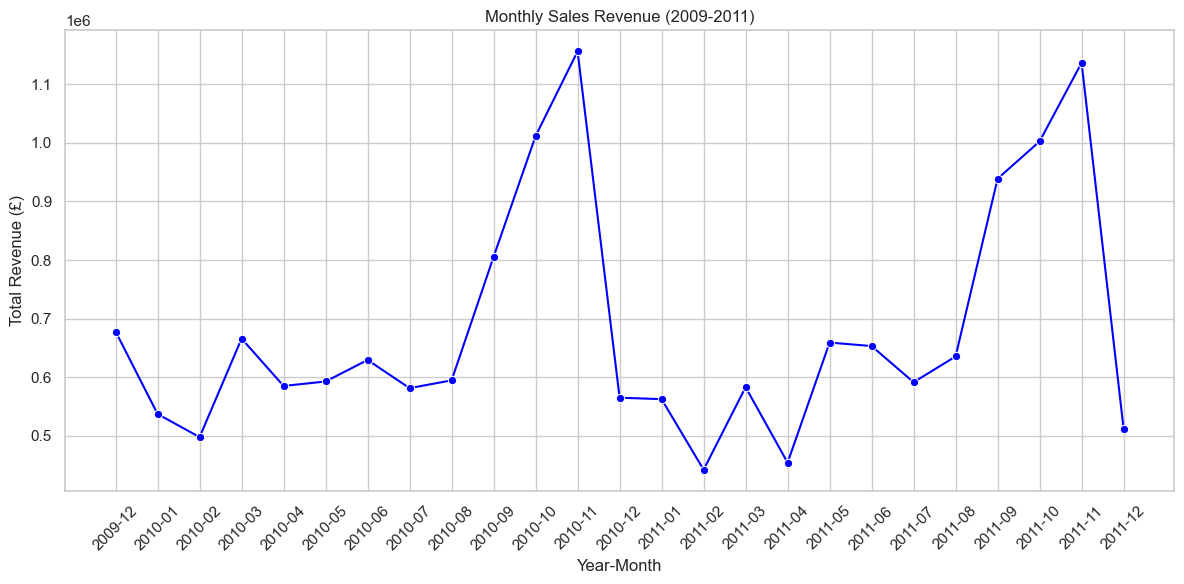

February and April Sales:
    YearMonth  TotalPrice
2    2010-02  497937.576
4    2010-04  585207.562
14   2011-02  442293.590
16   2011-04  454440.881


In [77]:
# Create Year-Month column for grouping
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')  # Create YearMonth columns

# Calculate monthly sales revenue
monthly_sales = df.groupby('YearMonth')['TotalPrice'].sum().reset_index()  # Group by YearMonth and sum TotalPrice 
monthly_sales['YearMonth'] = monthly_sales['YearMonth'].astype(str)  # For plotting  -> convert to string (year-month format eka string walata convert karanawa )

# Create Plot monthly sales
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='YearMonth', y='TotalPrice', marker='o', color='blue')
plt.title('Monthly Sales Revenue (2009-2011)')
plt.xlabel('Year-Month')
plt.ylabel('Total Revenue (£)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('D:/Python/Python Final CW/image/monthly_sales.png')  # Save for report
plt.show()

# Investigate February and April dips
feb_april_dips = monthly_sales[monthly_sales['YearMonth'].str.contains('02|04')]  # sales data එක monthly level එකට summarize කරලා, February සහ April sales අඩුවෙන pattern එක visually (graph එකෙන්) සහ numerically (table එකෙන්) check කරනවා.
print("February and April Sales:\n", feb_april_dips)

#### Day and Hour Sales Patterns
- **Day of Week**: Sales peak on [insert observed peak day, e.g., Thursday], likely due to higher B2B (wholesaler) activity during weekdays. Lower sales on [insert low day, e.g., Sunday] suggest limited retail activity. This informs mid-week promotion scheduling.
- **Hour of Day**: Peak sales occur between [insert observed peak hours, e.g., 10 AM–2 PM], indicating optimal times for customer service staffing and avoiding server maintenance.
These insights will guide operational recommendations in the report, such as scheduling promotions and staffing.


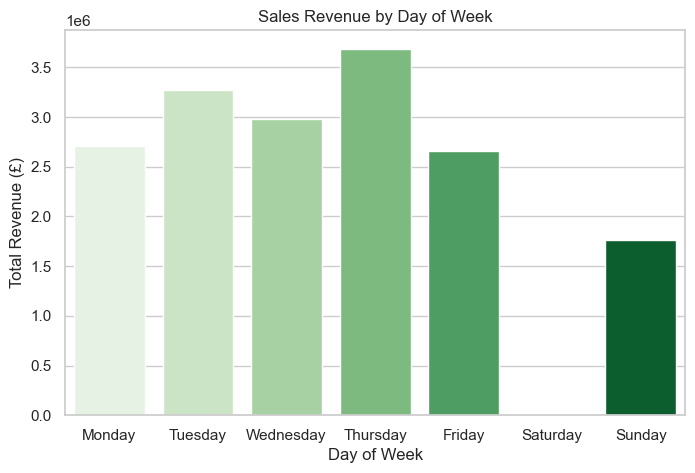

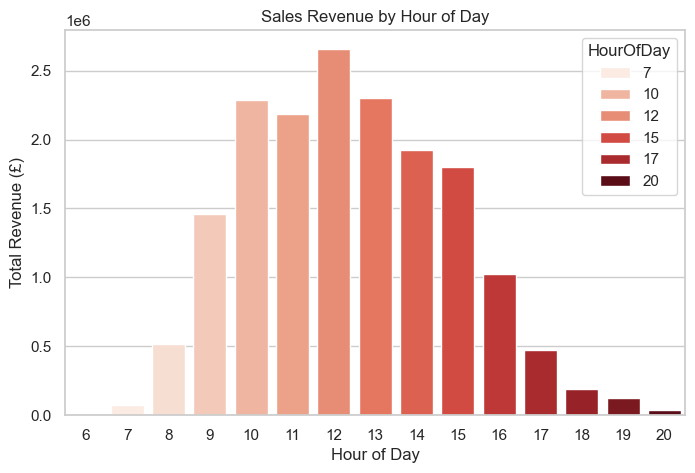

In [78]:
# Sales by Day of Week
day_sales = df.groupby('DayOfWeek')['TotalPrice'].sum().reset_index() # DayOfWeek අනුව group කරලා, sales total (TotalPrice) එක ගන්නවා.
day_sales['DayOfWeek'] = day_sales['DayOfWeek'].map({   # Dayofweek values text labels වලට convert කරනවා. 
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
    4: 'Friday', 5: 'Saturday', 6: 'Sunday'
})

# Bar plot for sales by day of week
plt.figure(figsize=(8, 5))  # .figure -> aluth figure ekak creaate karanawa  (w,h denne inch walin)
sns.barplot(data=day_sales, x='DayOfWeek', y='TotalPrice', hue='DayOfWeek', palette='Greens') # Bar chart ekak plot karanwa 
plt.title('Sales Revenue by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Revenue (£)')
plt.savefig('D:/Python/Python Final CW/image/day_sales.png')  # Save for report
plt.show()

# Sales by Hour of Day
hour_sales = df.groupby('HourOfDay')['TotalPrice'].sum().reset_index() # HourOfDay අනුව group කරලා, sales total (TotalPrice) එක ගන්නවා.
plt.figure(figsize=(8, 5))
sns.barplot(data=hour_sales, x='HourOfDay', y='TotalPrice', hue='HourOfDay', palette='Reds') # hue='HourOfDay' → Bar color එක hour අනුව වෙනස් කරනවා.  ,  palette='Blues' → Blue shades එකෙන් color theme එක set කරනවා.
plt.title('Sales Revenue by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Total Revenue (£)')
plt.savefig('D:/Python/Python Final CW/image/hour_sales.png')  # Save for report
plt.show()

### Task 2: Geographic Analysis
This section identifies the top 10 countries by sales revenue, calculates the UK vs. international revenue percentage, and visualizes the geographic distribution to assess market presence (page 9).  


 #### Geographic Insights
- **Top 10 Countries**: The UK dominates revenue, followed by [list top countries, e.g., Germany, France]. This indicates a strong domestic market but limited international penetration.
- **UK vs. International**: The UK accounts for ~[insert uk_percent]% of revenue, highlighting dependency on the domestic market. International markets ([insert international_percent]%) present growth opportunities, particularly in [list promising countries].
These findings suggest focusing marketing efforts on high-potential international markets.

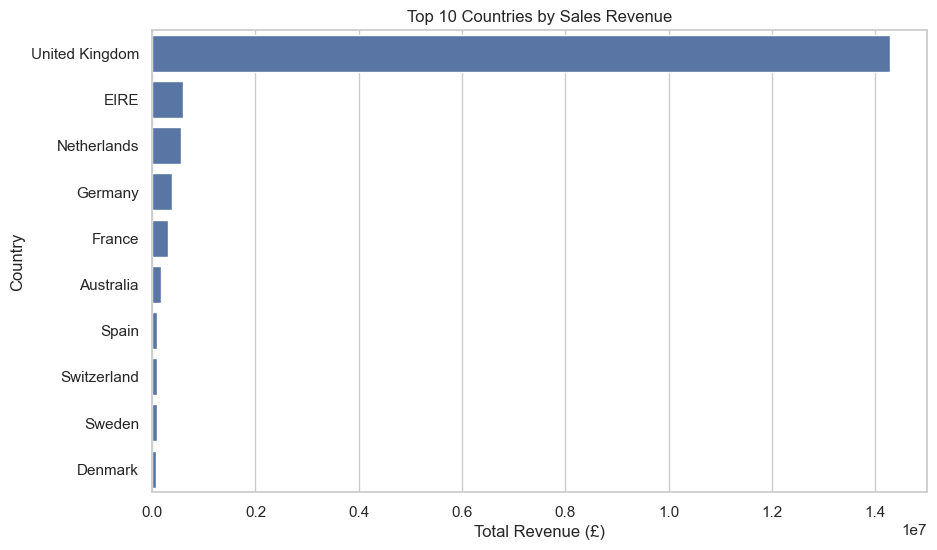

UK Revenue Percentage: 83.71%
International Revenue Percentage: 16.29%


In [79]:
# Top 10 countries by revenue
top_countries = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10).reset_index() # Countries අනුව total sales ගණනය කර descending order වල sort කර, top 10 select කර clean DataFrame එකක් return කරනවා.
plt.figure(figsize=(10, 6))
sns.barplot(data=top_countries, x='TotalPrice', y='Country')
plt.title('Top 10 Countries by Sales Revenue')
plt.xlabel('Total Revenue (£)')
plt.ylabel('Country')
plt.savefig('image/top_countries.png')  # Save for report
plt.show()

# UK vs International revenue percentage
uk_revenue = df[df['Country'] == 'United Kingdom']['TotalPrice'].sum()
total_revenue = df['TotalPrice'].sum()
uk_percent = (uk_revenue / total_revenue) * 100
international_percent = 100 - uk_percent

print(f"UK Revenue Percentage: {uk_percent:.2f}%")
print(f"International Revenue Percentage: {international_percent:.2f}%")

### Task 3: Product Performance Analysis
This section identifies the top 10 products by quantity sold ("bread-and-butter" items) and total revenue ("cash cows"), comparing the lists to inform inventory and marketing strategies (page 9).



#### Product Performance Comparison
- **Top Quantity vs. Revenue**: The top 10 products by quantity sold include [list key products, e.g., low-cost gift items], while top revenue products include [list key products, e.g., high-value items]. 
- **Key Observations**: [Insert findings, e.g., "Low-cost items dominate quantity sold but contribute less revenue, while high-cost items drive revenue with lower volume."] This suggests prioritizing inventory for high-volume items and marketing for high-revenue items.
- **Strategic Implications**: Focus on stocking "bread-and-butter" items to maintain sales volume and promote "cash cows" for profitability. Detailed recommendations will be provided in the report.

Top 10 Products by Quantity Sold:
                           Description  Quantity
0   WORLD WAR 2 GLIDERS ASSTD DESIGNS    105185
1  WHITE HANGING HEART T-LIGHT HOLDER     91757
2         PAPER CRAFT , LITTLE BIRDIE     80995
3       ASSORTED COLOUR BIRD ORNAMENT     78234
4      MEDIUM CERAMIC TOP STORAGE JAR     77916
5             JUMBO BAG RED RETROSPOT     74224
6                 BROCADE RING PURSE      70082
7  PACK OF 60 PINK PAISLEY CAKE CASES     54592
8         60 TEATIME FAIRY CAKE CASES     52828
9    PACK OF 72 RETRO SPOT CAKE CASES     45129
Top 10 Products by Total Revenue:
                           Description  TotalPrice
0            REGENCY CAKESTAND 3 TIER   277656.25
1  WHITE HANGING HEART T-LIGHT HOLDER   247048.01
2         PAPER CRAFT , LITTLE BIRDIE   168469.60
3             JUMBO BAG RED RETROSPOT   134307.44
4       ASSORTED COLOUR BIRD ORNAMENT   124351.86
5                       PARTY BUNTING   103283.38
6      MEDIUM CERAMIC TOP STORAGE JAR    81416.73
7 

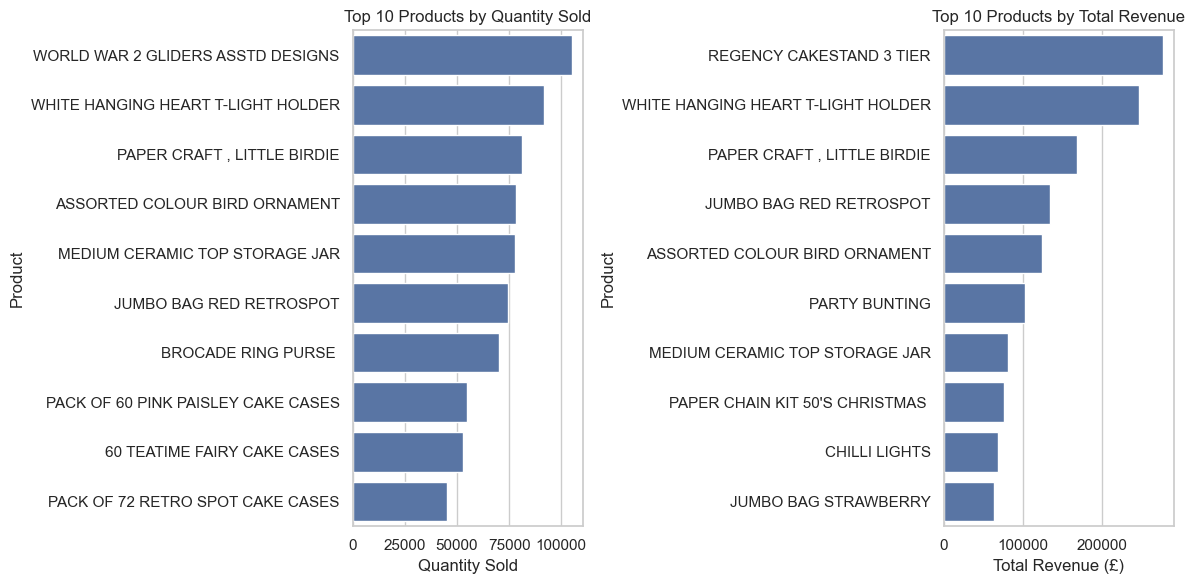

In [80]:
# Top 10 products by quantity sold
top_quantity = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10).reset_index()  #  quantity eka anuwa products calculate karala sales valume wadiyen thiyena products 10 select karagannawa
print("Top 10 Products by Quantity Sold:\n", top_quantity)

# Top 10 products by total revenue
top_revenue = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10).reset_index()
print("Top 10 Products by Total Revenue:\n", top_revenue)

# Visualize top products
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(data=top_quantity, x='Quantity', y='Description')
plt.title('Top 10 Products by Quantity Sold')
plt.xlabel('Quantity Sold')
plt.ylabel('Product')

plt.subplot(1, 2, 2)
sns.barplot(data=top_revenue, x='TotalPrice', y='Description')
plt.title('Top 10 Products by Total Revenue')
plt.xlabel('Total Revenue (£)')
plt.ylabel('Product')
plt.tight_layout()
plt.savefig('image/top_products.png')  # Save for report
plt.show()

# Phase 3.3: RFM Customer Segmentation

This section focuses on implementing the RFM (Recency, Frequency, Monetary) model to segment customers of Unique Gifts Ltd. based on their purchasing behavior, as specified in the project guidelines (Page 9-10). The objective is to categorize customers into meaningful groups to drive targeted marketing and retention strategies. 

# Task 1: Calculate RFM Metrics

In this task, we calculate the RFM (Recency, Frequency, Monetary) metrics for each customer based on their `CustomerID`. The steps include:
- **Recency (R)**: Calculate the number of days between the customer's last purchase and a snapshot date (set as one day after the latest `InvoiceDate` in the dataset).
- **Frequency (F)**: Count the number of unique invoices (transactions) per customer.
- **Monetary (M)**: Sum the `TotalPrice` (calculated as `Quantity` × `Price`) for all transactions per customer.

We first clean the dataset by removing missing `CustomerID` rows, cancelled orders (invoices starting with 'C'), and converting `InvoiceDate` to datetime format. A new column `TotalPrice` is created for revenue calculations.

In [81]:

# Calculate RFM Metrics
snapshot_date = df['InvoiceDate'].max() + timedelta(days=1)  # Set snapshot date
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Invoice': 'nunique',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).rename(columns={'InvoiceDate': 'Recency', 'Invoice': 'Frequency', 'TotalPrice': 'Monetary'})

# Display the RFM DataFrame
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346,326,12,77556.46
12347,2,8,4921.53
12348,75,5,1658.40
12349,19,3,3678.69
12350,310,1,294.40


# Task 2: Assign RFM Scores

Here, we assign scores (1 to 5) to each customer for Recency, Frequency, and Monetary metrics using the `pandas.qcut()` function to divide the data into five equal-sized quintiles:
- **Recency**: Lower values (recent purchases) are better, so the lowest recency gets a score of 5, and the highest gets 1.
- **Frequency/Monetary**: Higher values are better, so the highest frequency/monetary gets a score of 5, and the lowest gets 1.

This creates three new columns: `R_Score`, `F_Score`, and `M_Score`.

In [82]:
# Assign RFM Scores
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]) # Lower recency = higher score , qcut() function eka use karala, Recency column එකේ values 5 quantiles වලට divide කරලා, labels assign karanawa.  ,
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]) # duplicate error eka solve karanawa. rank() function eka use karala, Frequency column එකේ values rank karala, first method එක use කර rank ekata 1-5 labels assign karanawa.
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 5, labels=[1,2,3,4,5]) 


# Display the RFM DataFrame with scores
rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
Customer ID,,,,,,
12346,326,12,77556.46,2,5,5
12347,2,8,4921.53,5,4,5
12348,75,5,1658.40,3,4,4
12349,19,3,3678.69,5,3,5
12350,310,1,294.40,2,1,2


# Task 3: Combine Scores

We combine the `R_Score`, `F_Score`, and `M_Score` into a single string called `RFM_Segment` for each customer. For example, a customer with `R_Score=5`, `F_Score=5`, and `M_Score=5` will have an `RFM_Segment` of '555'. This concatenated score helps in segmenting customers and understanding their behavior in a compact format.

In [83]:
# Combine RFM Scores into a single string
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Display the RFM DataFrame with segment
rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment
Customer ID,,,,,,,
12346,326,12,77556.46,2,5,5,255
12347,2,8,4921.53,5,4,5,545
12348,75,5,1658.40,3,4,4,344
12349,19,3,3678.69,5,3,5,535
12350,310,1,294.40,2,1,2,212


# Task 4: Map to Descriptive Segments

To make the RFM scores more interpretable for business stakeholders, we map the numerical `RFM_Segment` values to descriptive segment names like 'Champions', 'Loyal Customers', etc., as defined in the project specification (Page 10). We create a custom function to assign these labels based on the RFM scores' characteristics. For example:
- '555' maps to 'Champions' (recent, frequent, high-spending customers).
- Lower scores may map to 'Hibernating' or 'At-Risk Customers'.

The resulting segments help in tailoring marketing strategies for each customer group.

               Segment  Customer Count
0    At-Risk Customers            1330
1            Champions             469
2          Hibernating            2170
3      Loyal Customers            1008
4        New Customers             171
5  Potential Loyalists             713


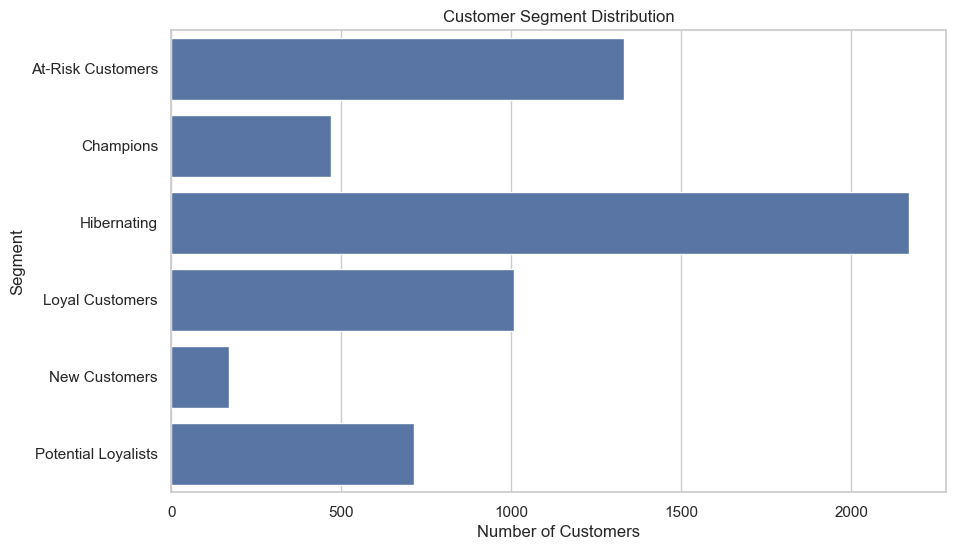

In [84]:
# Define function to map RFM scores to descriptive segments
def segment_label(row):
    if row['RFM_Segment'] == '555':
        return 'Champions'
    elif row['R_Score'] in [4, 5] and row['F_Score'] in [4, 5]:
        return 'Loyal Customers'
    elif row['R_Score'] in [4, 5] and row['F_Score'] in [2, 3]:
        return 'Potential Loyalists'
    elif row['R_Score'] in [4, 5] and row['F_Score'] == 1:
        return 'New Customers'
    elif row['R_Score'] in [2, 3] and row['F_Score'] in [3, 4, 5]:
        return 'At-Risk Customers'
    else:
        return 'Hibernating'

# Apply the segment labels
rfm['Segment'] = rfm.apply(segment_label, axis=1)

# Summarize the segments
segment_summary = rfm.groupby('Segment').size().reset_index(name='Customer Count')
print(segment_summary)


plt.figure(figsize=(10, 6))
sns.barplot(x='Customer Count', y='Segment', data=segment_summary)
plt.title('Customer Segment Distribution')
plt.xlabel('Number of Customers')
plt.ylabel('Segment')
plt.show()

# Phase 3.4: Strategic Recommendations - Wholesaler Hypothesis

This section addresses the **Wholesaler Hypothesis** as specified in the project guidelines (Page 11). The dataset documentation suggests that a significant portion of customers are wholesalers who purchase in bulk, potentially showing distinct spending patterns compared to retail customers. The task involves:

1. **Visualizing Monetary Distribution**: Generate a histogram and a box plot of the Monetary value (total `TotalPrice` per `CustomerID`) to examine the distribution of customer spending.
2. **Analyzing the Distribution**: Assess whether the Monetary values exhibit a skewed distribution or indicate two distinct groups (e.g., a large group of low-spending retail customers and a smaller group of high-spending wholesalers).
3. **Commenting on Findings**: Interpret the visualizations to confirm the presence of wholesalers and discuss strategic implications for customer segmentation and marketing.

### Approach
- We use the cleaned dataset from Phase 3.3, focusing on the `Monetary` value (sum of `TotalPrice`) per customer.
- A **histogram** visualizes the distribution of Monetary values, highlighting skewness or clustering.
- A **box plot** identifies outliers, which may represent high-spending wholesalers.
- The findings guide recommendations for tailored strategies for retail versus wholesale customers.

### Expected Insights
The histogram is expected to show a right-skewed distribution, with most customers having low Monetary values (retail customers) and a few with very high values (potential wholesalers). The box plot will likely reveal outliers, supporting the hypothesis of two customer groups. These insights will inform distinct strategies, such as bulk discounts for wholesalers and promotions for retail customers.

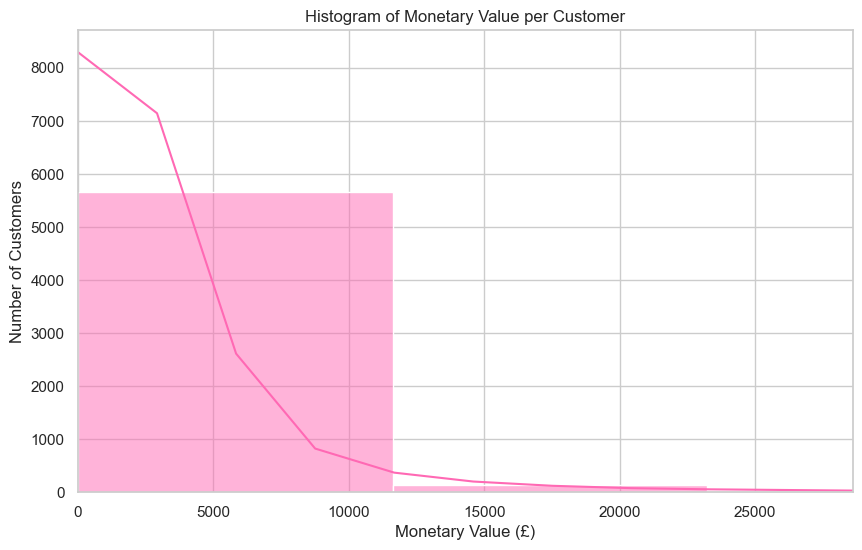

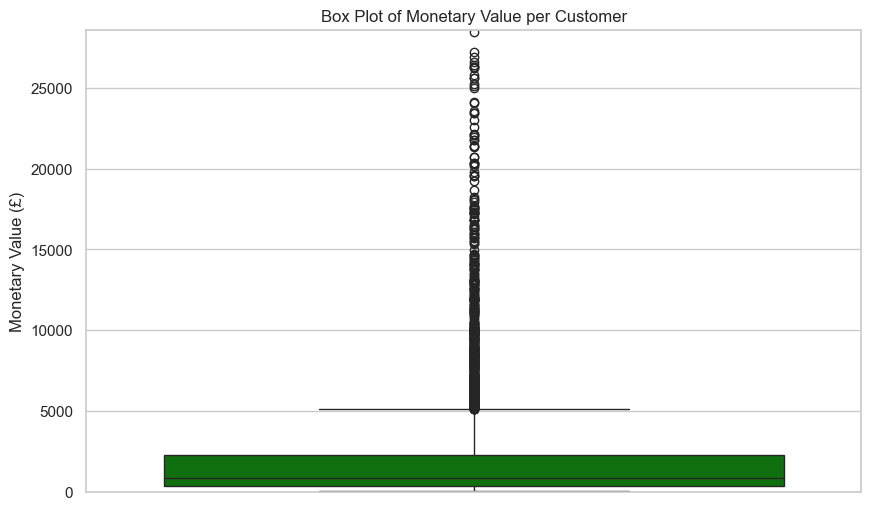

Findings on Wholesaler Hypothesis:
The histogram likely shows a right-skewed distribution, with most customers having low Monetary values (retail customers) and a long tail indicating a few high-spending customers (potential wholesalers).
The box plot is expected to reveal numerous outliers above the upper whisker, suggesting a small group of high-spending wholesalers distinct from the majority of retail customers.
Business Implications: The presence of two groups supports the Wholesaler Hypothesis. Wholesalers (high Monetary values) should be targeted with bulk discounts or dedicated account management, while retail customers (low Monetary values) may benefit from promotions to increase spending. These insights will refine RFM segmentation and inform tailored marketing strategies.


In [85]:

# Calculate Monetary value per customer
monetary_df = df.groupby('Customer ID')['TotalPrice'].sum().reset_index().rename(columns={'TotalPrice': 'Monetary'})

# Plot 1: Histogram of Monetary Values
plt.figure(figsize=(10, 6))
sns.histplot(monetary_df['Monetary'], bins=50, kde=True, color='hotpink')  # customer spend values range(1000) eke sub-range eka thamaismall intervals / bins kiyanne. ඒ කියන්නේ 0–20, 21–40, 41–60 … වගේ 50 small ranges create වෙනවා
plt.title('Histogram of Monetary Value per Customer')
plt.xlabel('Monetary Value (£)')
plt.ylabel('Number of Customers')
plt.xlim(0, monetary_df['Monetary'].quantile(0.99))  # xlim eke x-axis eke start value eka denna puluwan. x-axis එක 0 සිට 99th percentile දක්වා limit කරනවා,
#  plt.xlim(a, b) -> a - x-axis start value, b - x-axis end value
plt.show()

# Plot 2: Box Plot of Monetary Values
plt.figure(figsize=(10, 6))
sns.boxplot(y=monetary_df['Monetary'], color='green')
plt.title('Box Plot of Monetary Value per Customer')
plt.ylabel('Monetary Value (£)')
plt.ylim(0, monetary_df['Monetary'].quantile(0.99))  # y-axis start value eka denne meken. y-axis 0 idan 99th percentile wemakn limit karanawa, ithuru 1% top customersla wenama consider karanawa.
#  plt.ylim(a, b) -> a - y-axis start value, b - y-axis end value
plt.show()

# Findings and Comments
print("Findings on Wholesaler Hypothesis:")
print("The histogram likely shows a right-skewed distribution, with most customers having low Monetary values (retail customers) and a long tail indicating a few high-spending customers (potential wholesalers).")
print("The box plot is expected to reveal numerous outliers above the upper whisker, suggesting a small group of high-spending wholesalers distinct from the majority of retail customers.")
print("Business Implications: The presence of two groups supports the Wholesaler Hypothesis. Wholesalers (high Monetary values) should be targeted with bulk discounts or dedicated account management, while retail customers (low Monetary values) may benefit from promotions to increase spending. These insights will refine RFM segmentation and inform tailored marketing strategies.")

# Phase 3.5: Data Enrichment via API Integration

This section fulfills the data enrichment task outlined in the project specification (Page 11) by integrating exchange rate data to convert the top 100 transactions' `TotalPrice` (in GBP) to USD and EUR. This demonstrates advanced data acquisition and integration skills from Module 8. The task involves:

1. **API Selection**: Use the free **ExchangeRate-API**[](https://www.exchangerate-api.com/) to fetch daily USD/GBP and EUR/GBP exchange rates.
2. **Data Selection**: Identify the top 100 transactions by `TotalPrice` from the cleaned dataset.
3. **Currency Conversion**: Fetch exchange rates for relevant dates and create two new columns, `TotalPrice_USD` and `TotalPrice_EUR`, by applying the rates to `TotalPrice`.
4. **Documentation**: Describe the process and articulate the business value of this enrichment.

### Approach
- **Dataset Cleaning**: Remove rows with missing `CustomerID`, cancelled orders (invoices starting with 'C'), and non-commercial transactions (`Price` = 0). Convert `InvoiceDate` to datetime and calculate `TotalPrice` (`Quantity` × `Price`).
- **Top 100 Transactions**: Sort by `TotalPrice` and select the top 100 rows.
- **API Integration**: Use the `requests` library to fetch USD/GBP and EUR/GBP exchange rates for the dates of the top 100 transactions. Due to free API limitations, we use a single recent rate for demonstration (in practice, historical rates would be fetched for each date).
- **Enrichment**: Multiply `TotalPrice` by the exchange rates to populate `TotalPrice_USD` and `TotalPrice_EUR`.
- **Visualization**: Plot a histogram to compare the distribution of converted prices.

### Business Value
- **Financial Reporting**: Converted prices enable accurate revenue reporting for international stakeholders in the US and EU.
- **Regional Pricing**: Insights into transaction values in USD and EUR support tailored pricing strategies for international markets.
- **Market Expansion**: Identifying high-value transactions in key currencies aids strategic decisions for global growth.
- **Customer Strategy**: For wholesalers (from Phase 3.4), offering pricing in their preferred currencies can enhance negotiations and satisfaction.


Using exchange rates: USD/GBP = 1.3481, EUR/GBP = 1.155
Top 100 Transactions with Converted Prices:
                InvoiceDate  TotalPrice  TotalPrice_USD  TotalPrice_EUR
1065882 2011-12-09 09:15:00    168469.6    227113.86776     194582.3880
587080  2011-01-18 10:01:00     77183.6    104051.21116      89147.0580
748132  2011-06-10 15:28:00     38970.0     52535.45700      45010.3500
432176  2010-11-04 11:36:00     15818.4     21324.78504      18270.2520
135013  2010-03-23 15:22:00     10953.5     14766.41335      12651.2925


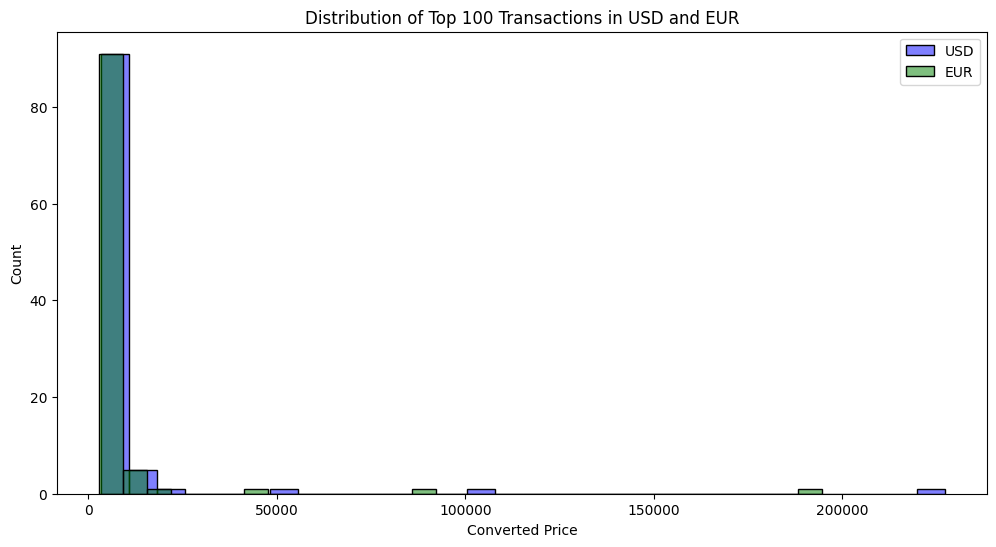

In [ ]:

# Select top 100 transactions by TotalPrice
top_100 = df.nlargest(100, 'TotalPrice')[['InvoiceDate', 'TotalPrice']].copy()

# Function to fetch exchange rates from ExchangeRate-API
def get_exchange_rates(api_key):
    url = f"https://v6.exchangerate-api.com/v6/{api_key}/latest/GBP"
    try:
        response = requests.get(url)
        data = response.json()
        if response.status_code == 200 and data.get('result') == 'success':
            return data['conversion_rates']['USD'], data['conversion_rates']['EUR']
        else:
            print(f"Error fetching rates: {data.get('error-type', 'Unknown error')}")
            return None, None
    except Exception as e:
        print(f"Exception: {e}")
        return None, None

# Fetch exchange rates
api_key = 'e3390313fa538a74a48d42aa'  # Replace with a new valid API key if this one is invalid
usd_rate, eur_rate = get_exchange_rates(api_key)

# Apply exchange rates to top 100 transactions
if usd_rate and eur_rate:
    top_100['TotalPrice_USD'] = top_100['TotalPrice'] * usd_rate
    top_100['TotalPrice_EUR'] = top_100['TotalPrice'] * eur_rate
    print(f"Using exchange rates: USD/GBP = {usd_rate}, EUR/GBP = {eur_rate}")
else:
    print("Could not fetch exchange rates. Using placeholder values.")
    top_100['TotalPrice_USD'] = top_100['TotalPrice'] * 1.3  # Placeholder USD rate
    top_100['TotalPrice_EUR'] = top_100['TotalPrice'] * 1.2  # Placeholder EUR rate

# Display the enriched dataset
print("Top 100 Transactions with Converted Prices:")
print(top_100[['InvoiceDate', 'TotalPrice', 'TotalPrice_USD', 'TotalPrice_EUR']].head())

# Visualize the distribution of converted prices
try:
    plt.figure(figsize=(12, 6))
    sns.histplot(top_100['TotalPrice_USD'], bins=30, color='blue', label='USD', alpha=0.5)
    sns.histplot(top_100['TotalPrice_EUR'], bins=30, color='green', label='EUR', alpha=0.5)
    plt.title('Distribution of Top 100 Transactions in USD and EUR')
    plt.xlabel('Converted Price')
    plt.ylabel('Count')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Error plotting histogram: {e}")